In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import lstsq, norm, eig, pinv
from scipy.sparse.linalg import lsqr
from scipy.sparse import spdiags, eye, kron
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def first_diffs_2d_matrix(m,n):
# % Construct circulant first differences matrix 
    Im = eye(m)
    In = eye(n)
    
    dn = np.vstack((n*[-1], n*[1]))
    dm = np.vstack((m*[-1], m*[1]))

    Dm = spdiags(dm, [0, 1], m, m)
    Dn = spdiags(dn, [0, 1], n, n)

    A = sp.vstack((kron(Dn, Im),      #  % First differences across rows
                   kron(In, Dm)))     #  % First differences down columns
    
    return A

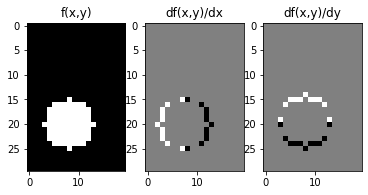

In [3]:
# Finite difference of a matrix in both x and y directions

# problem size
m, n = 30, 20
cols, rows = np.meshgrid(np.arange(n),np.arange(m))

# disk parameters
cx = 8
cy = 20
r = 5

# create matrix with disk
X = (rows-cy)**2 + (cols-cx)**2 <= r**2

plt.figure()
plt.subplot(131)
plt.imshow(X, cmap='gray')
plt.title('f(x,y)')

# test your first diffs matrix
A = first_diffs_2d_matrix(m,n)

x = X.flatten('F').astype(int)
DFDX = A.toarray()[:m*n,:] @ x
DFDY = A.toarray()[m*n:,:] @ x

plt.subplot(132)
plt.imshow(np.reshape(DFDX, (m,n), order='F'), cmap='gray')
plt.title('df(x,y)/dx')

plt.subplot(133)
plt.imshow(np.reshape(DFDY, (m,n), order='F'), cmap='gray')
plt.title('df(x,y)/dy');

In [4]:
from sklearn.preprocessing import normalize
def compute_normals(I,L):        
# % Inputs:       I is an (m x n x d) matrix whose d slices contain m x n
# %               double-precision images of a common scene under different
# %               lighting conditions
# %               
# %               L is a (3 x d) matrix such that L(:,i) is the lighting
# %               direction vector for image I(:,:,i)
# %               
# % Outputs:      N is an (m x n x 3) matrix containing the unit-norm surface
# %               normal vectors for each pixel in the scene
    m, n, d = I.shape

    I_reshaped = I.reshape(m*n, d)    
    N = lstsq(L.T, I_reshaped.T)[0]
    
    N = normalize(N,norm='l2',axis=1,copy=False)
    N = N.T.reshape(m,n,3)

    return N

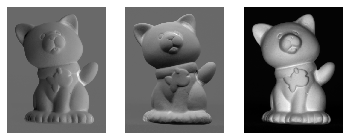

In [5]:
from scipy.io import loadmat
# load data
# I = images   (m x n x d)
# L = lighting (3 x d) 
# M = mask     (m x n)
catData = loadmat('cat.mat')
I = catData['I']
L = catData['L']
M = catData['M']

m, n, d = I.shape

N = compute_normals(I, L)

plt.figure()
plt.subplot(131)
plt.imshow(N[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(N[:,:,1], cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(N[:,:,2], cmap='gray')
plt.axis('off');

In [6]:
# Compute gradients from normals
DFDX = -N[:,:,0] / N[:,:,2]       
DFDY =  N[:,:,1] / N[:,:,2]
DFDX[np.isnan(DFDX)] = 0         # Clean data
DFDX[M==0] = 0                   # Apply mask
DFDY[np.isnan(DFDY)] = 0         # Clean data
DFDY[M==0] = 0                   # Apply mask

dfdx = DFDX.flatten('F').astype(int)
dfdy = DFDY.flatten('F').astype(int)

# Construct least-squares problem from gradients
A = first_diffs_2d_matrix(m,n)
b = np.concatenate((dfdx,dfdy))

/Users/pmw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/pmw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Built-in solver
fxy = lsqr(A, b, iter_lim=1000)[0]

# Format surface
FXY = np.reshape(fxy, [m,n], order='F')  # Reshape into matrix
FXY = FXY - np.amin(FXY[M])              # Anchor to z-axis
FXY = FXY * M                            # Apply mask

# Set up surface plot axes
X = np.arange(n)
Y = np.arange(m)
X, Y = np.meshgrid(X, Y)

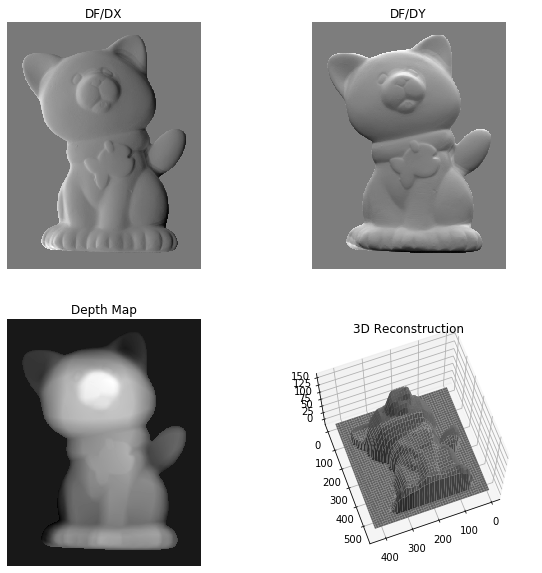

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(DFDX, cmap='gray')
ax.axis('off')
ax.set_title('DF/DX')

ax = fig.add_subplot(2, 2, 2)
ax.imshow(DFDY, cmap='gray')
ax.axis('off')
ax.set_title('DF/DY')

ax = fig.add_subplot(2, 2, 3)
ax.imshow(FXY, cmap='gray')
ax.axis('off')
ax.set_title('Depth Map')

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X, Y, np.fliplr(FXY), color='gray', alpha=1.0, linewidth=0)
ax.view_init(elev=70,azim=70)
ax.set_title('3D Reconstruction');